In [1]:
import cantera as ct
import cantera.ck2cti as ck2cti
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Converting from Chemkin

In [2]:
# command line equivalent:
# python -m cantera.ck2cti --input=mech.txt --thermo=thermo.txt --transport=tran.txt --permissive --out=mech.cti
parser = ck2cti.Parser()
#parser.convertMech('mech.txt', 'thermo.txt', 'tran.txt', outName='mech.cti')
#parser.convertMech('mech_fixed.txt', 'thermo.txt', 'tran.txt', outName='mech.cti')
#parser.convertMech('mech_fixed.txt', 'thermo_fixed.txt', 'tran.txt', outName='mech.cti')
parser.convertMech('mech_fixed.txt', 'thermo_fixed.txt', 'tran.txt', permissive=True, outName='mech.cti')

INFO:root:Skipping unexpected species "C3H4CY" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "C4H5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH3NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "CH2NO3" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "HCCOH" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "N2O5" while reading thermodynamics entry.
INFO:root:Skipping unexpected species "TC4H7" while reading thermodynamics entry.


Wrote CTI mechanism file to 'mech.cti'.
Mechanism contains 129 species and 1231 reactions.


[]

## Thermo Data

In [3]:
gas = ct.Solution('mech.cti')



**** WARNING ****
For species HCNH, discontinuity in cp/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  14.1403
	Value computed using high-temperature polynomial: 8.62009


**** WARNING ****
For species HCNH, discontinuity in h/RT detected at Tmid = 1500
	Value computed using low-temperature polynomial:  31.9298
	Value computed using high-temperature polynomial: 31.3834


**** WARNING ****
For species HCNH, discontinuity in s/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  38.9438
	Value computed using high-temperature polynomial: 38.3468


**** WARNING ****
For species H2CNO, discontinuity in cp/R detected at Tmid = 1500
	Value computed using low-temperature polynomial:  22.7915
	Value computed using high-temperature polynomial: 11.3588


**** WARNING ****
For species H2CNO, discontinuity in h/RT detected at Tmid = 1500
	Value computed using low-temperature polynomial:  26.491
	Value computed using high-temperature polynomial

<IPython.core.display.Javascript object>


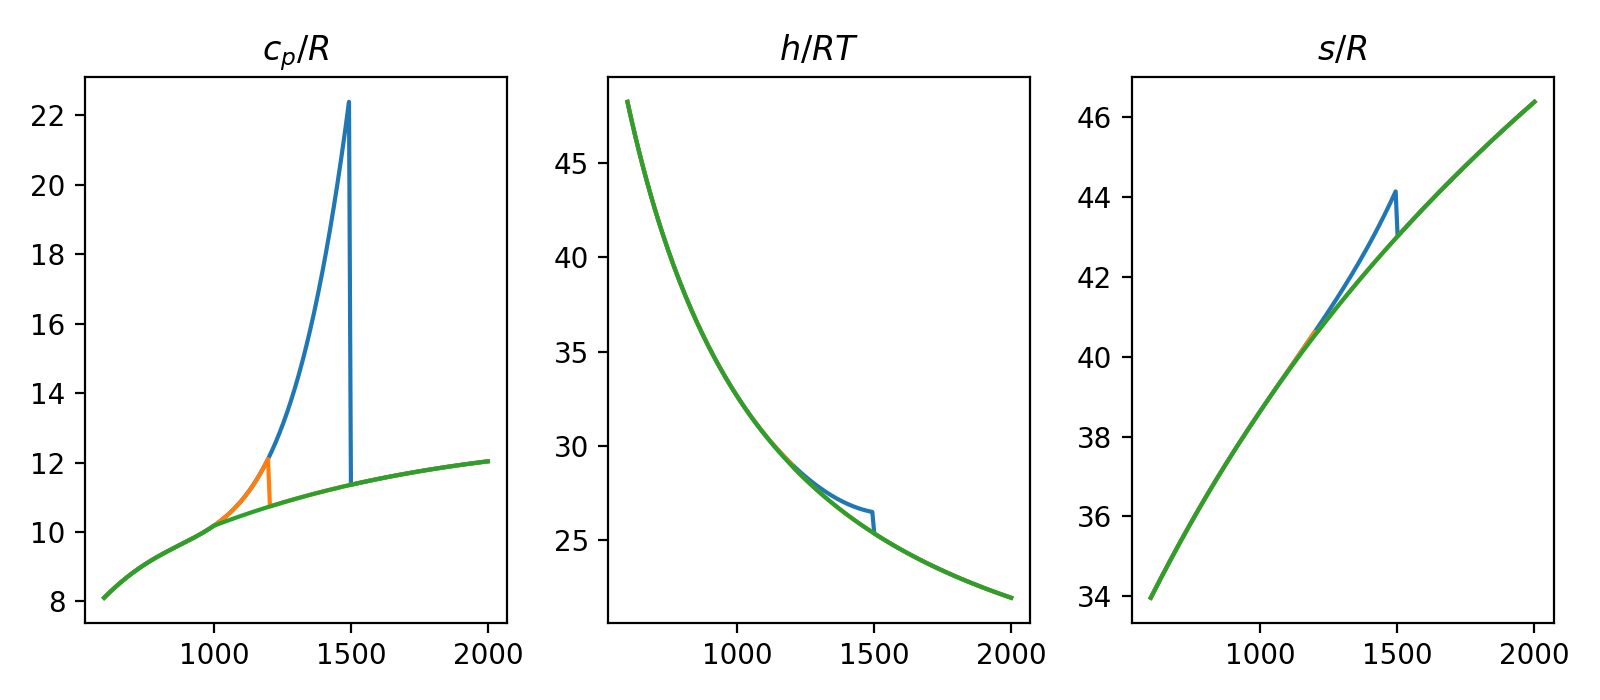

In [4]:
sp = gas.species('H2CNO')
T = np.linspace(600, 2000, 200)
f,ax = plt.subplots(1,3, figsize=(8,3.5))

def plot_thermo(thermo):
    h = [thermo.h(tt)/(ct.gas_constant * tt) for tt in T]
    cp = [thermo.cp(tt)/ct.gas_constant for tt in T]
    s = [thermo.s(tt)/ct.gas_constant for tt in T]
    ax[0].plot(T,cp)
    ax[0].set_title('$c_p/R$')
    ax[1].plot(T,h)
    ax[1].set_title('$h/RT$')
    ax[2].plot(T,s)
    ax[2].set_title('$s/R$')
    f.tight_layout()
plot_thermo(sp.thermo)

In [5]:
c0 = sp.thermo.coeffs
c0

array([  1.50000000e+03,   5.40281520e+00,   6.90570010e-03,
        -2.51629770e-06,   4.10140660e-10,  -2.47183000e-14,
         2.45286900e+04,  -4.45742620e+00,   3.87818580e+00,
        -6.65308860e-03,   5.39476100e-05,  -6.81768130e-08,
         2.71817460e-11,   2.57168570e+04,   7.46187740e+00])

In [6]:
c0[0] = 1200
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

In [7]:
c0[0] = 1000
test = ct.NasaPoly2(sp.thermo.min_temp, sp.thermo.max_temp, sp.thermo.reference_pressure, c0)
plot_thermo(test)

## Reaction Rates

In [8]:
gas.TPX = 300, 101325, 'CH4:1.0, O2:0.1'
gas.equilibrate('TP')

<IPython.core.display.Javascript object>


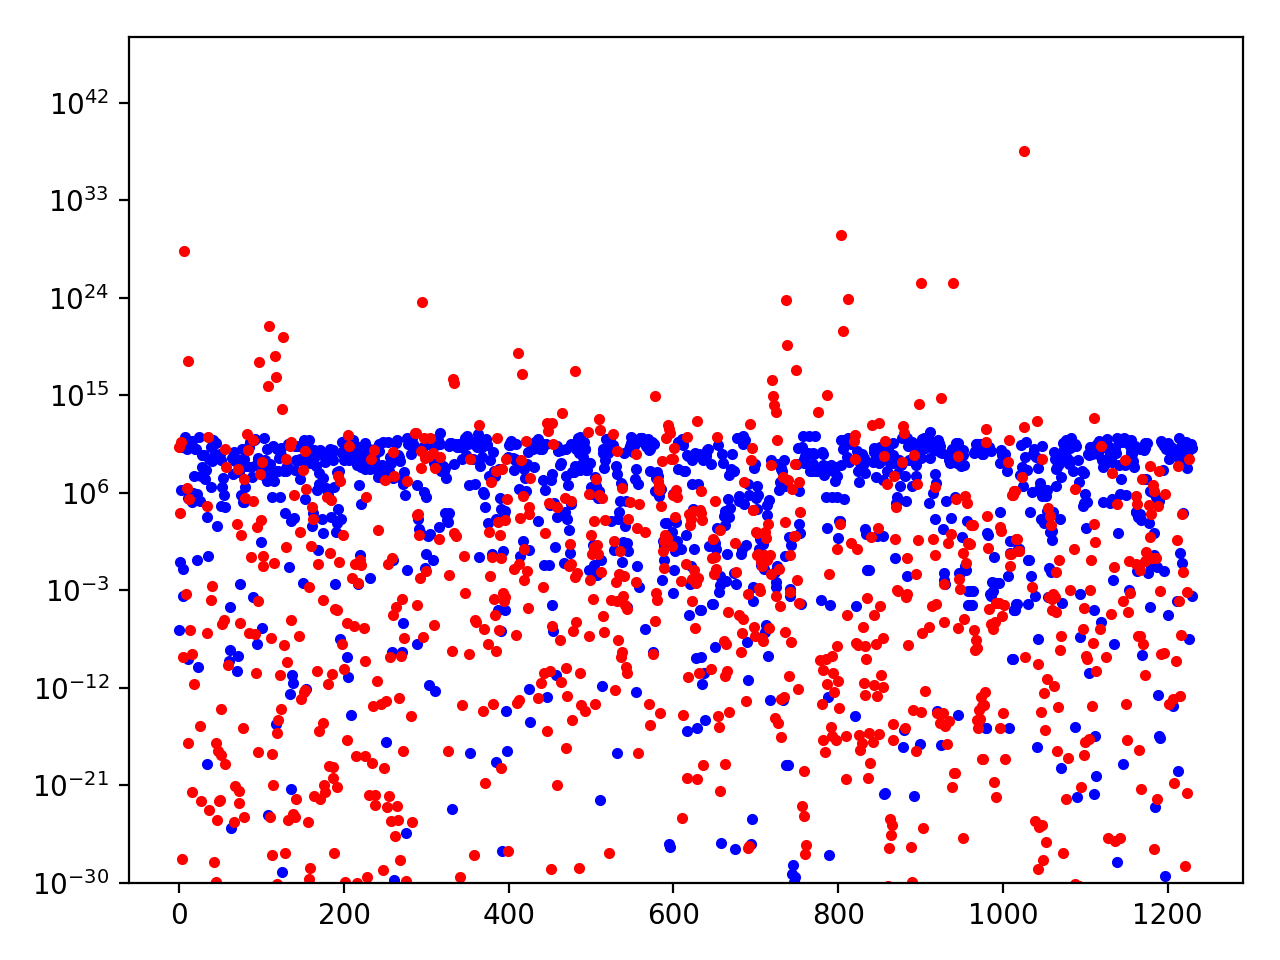

In [9]:
f,ax = plt.subplots(1,1)
ax.semilogy(gas.forward_rate_constants, 'b.')
ax.semilogy(gas.reverse_rate_constants, 'r.')
ax.set_ylim(ymin=1e-30)
f.tight_layout()

In [10]:
kr = gas.reverse_rate_constants
for i,k in enumerate(kr):
    if k > 1e20:
        print(i,k, gas.reaction_equation(i))

6 2.07444289308e+28 HNCN + M <=> H + NCN + M
109 2.27195058905e+21 N2H2 + M <=> 2 NH + M
126 2.13384413618e+20 N2H4 + M <=> H + N2H3 + M
295 4.26567203854e+23 CH3 + M <=> CH + H2 + M
737 5.80531321893e+23 C3H6 + O2 <=> HO2 + SC3H5
803 6.71165799908e+29 C3H3 + H <=> C3H2 + H2
806 7.61719246642e+20 C3H3 + OH <=> C3H2 + H2O
812 7.21882354968e+23 C2H2 + CH <=> C3H2 + H
900 2.1230833091e+25 C4H2 (+M) <=> C4H + H (+M)
939 2.13700653963e+25 PC3H4 <=> C2H + CH3
1026 3.30306107011e+37 C2N2 + M <=> 2 CN + M


In [11]:
gri = ct.Solution('gri30.cti')
for i,r in enumerate(gri.reactions()):
    if 'CH3' in r and 'H2' in r and 'CH' in r:
        print(i, r)

288 CH + H2 (+M) <=> CH3 (+M)


<IPython.core.display.Javascript object>


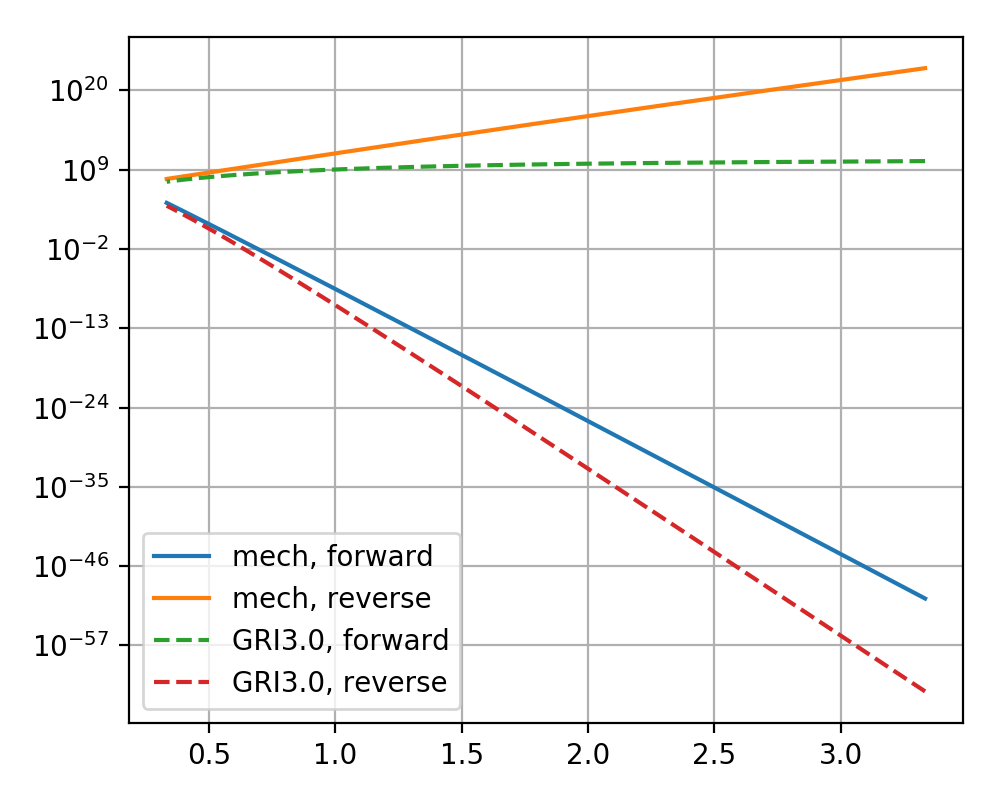

In [12]:
gasN = ct.SolutionArray(gas, shape=200)
griN = ct.SolutionArray(gri, shape=200)
T = np.linspace(300, 3000, 200)
gasN.TPY = T, 101325, 'N2:1.0'
griN.TPY = T, 101325, 'N2:1.0'

f,ax = plt.subplots(1,1, figsize=(5,4))
ax.semilogy(1000/T, gasN.forward_rate_constants[:,295], label='mech, forward')
ax.semilogy(1000/T, gasN.reverse_rate_constants[:,295], label='mech, reverse')
ax.semilogy(1000/T, griN.forward_rate_constants[:,288], '--', label='GRI3.0, forward')
ax.semilogy(1000/T, griN.reverse_rate_constants[:,288], '--', label='GRI3.0, reverse')
ax.legend(loc='best')
ax.grid(True)
f.tight_layout()